In [1]:
import scipy.optimize as sco
import scipy.stats as scs
import scipy.interpolate as sci
import statsmodels.api as sm
import numpy as np
import pandas as pd
from pandas_datareader import data, wb
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
symbols = ['AAPL','MSFT','AABA','DB','GLD']

fin_data = pd.DataFrame()
for sym in symbols:
    fin_data[sym] = data.DataReader(sym, data_source='yahoo', start='2014-09-12')['Adj Close']
fin_data.symbols = symbols

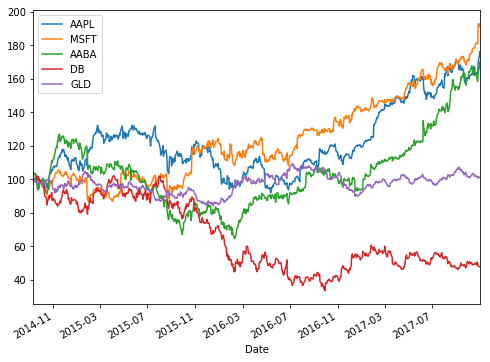

In [3]:
(fin_data/fin_data.iloc[0]*100.).plot(figsize=(8,6))

In [4]:
# calculate log of daily returns
rets = np.log(fin_data/fin_data.shift(1)).dropna()
rets.head()

,AAPL,MSFT,AABA,DB,GLD
Date,,,,,
2014-09-12,0.002265,-0.006403,0.038512,-0.006261,-0.009166
2014-09-15,-0.000295,-0.009899,-0.007726,-0.003145,0.002194
2014-09-16,-0.007605,0.011183,0.003753,0.001145,0.001600
2014-09-17,0.007113,-0.005146,-0.002814,0.002856,-0.010915
2014-09-18,0.002065,0.003434,-0.011809,0.020328,0.002040


In [5]:
rets.mean()*252

AAPL    0.180433
MSFT    0.206490
AABA    0.168950
DB     -0.234552
GLD     0.003184
dtype: float64

In [6]:
rets.cov()*252

,AAPL,MSFT,AABA,DB,GLD
AAPL,0.052840,0.025944,0.023187,0.023642,-0.003992
MSFT,0.025944,0.051118,0.026148,0.028346,-0.004337
AABA,0.023187,0.026148,0.079359,0.029438,-0.003887
DB,0.023642,0.028346,0.029438,0.154490,-0.013364
GLD,-0.003992,-0.004337,-0.003887,-0.013364,0.020592


In [7]:
# draw random asset allocation
noa = len(symbols)
weights = np.random.random(noa)
weights /= np.sum(weights)
weights

array([ 0.14308204,  0.16975165,  0.42634663,  0.07644096,  0.18437873])

In [8]:
# expected return of portfolio
np.sum(rets.mean()*weights)*252

0.1155576264257928

In [9]:
# expected portfolio variance
np.dot(weights.T, np.dot(rets.cov() * 252,weights))

0.028158380634750159

In [10]:
# expected portfolio sqrt
np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252,weights)))

0.16780459062478045

In [11]:
# simulate random allocations and calculate expected return vs. volatility
prets = []
pvols = []
for p in range(2500):
    # random weights
    weights = np.random.random(noa)
    weights /= np.sum(weights)
    prets.append(np.sum(rets.mean()*weights)*252)
    pvols.append(np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252,weights))))
prets = np.array(prets)
pvols = np.array(pvols)

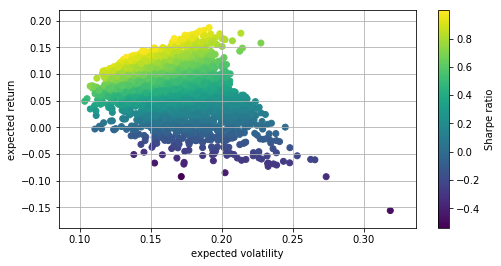

In [12]:
plt.figure(figsize=(8, 4))
plt.scatter(pvols, prets, c=prets/pvols, marker='o')
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio') # returns over risk

In [13]:
def statistics(weights):
    weights = np.array(weights)
    pret = np.sum(rets.mean() * weights) * 252
    pvol = np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))
    return np.array([pret, pvol, pret/pvol])

In [14]:
# we are looking to maximise the sharpe ratio (hence minimise the -ve)
def min_sharpe_function(weights):
    return -statistics(weights)[2]

In [15]:
# we have the constraint that the sum of the weights must equal 1
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

In [16]:
# each weight must be 0 <= w <= 1
bnds = tuple((0,1) for x in range(noa))

In [17]:
# this will be our starting point in weight space
noa * [1. / noa,]

[0.2, 0.2, 0.2, 0.2, 0.2]

In [18]:
# we our optimising the sharpe ratio in the weight space
#%%time
opts = sco.minimize(min_sharpe_function, noa * [1./noa,],method='SLSQP', bounds=bnds, constraints=cons)

In [19]:
opts

     fun: -1.0199815558688432
     jac: array([  2.47925520e-04,  -1.49801373e-04,  -4.76509333e-04,
         2.35360312e+00,   2.67028809e-04,   0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 49
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([  2.69429312e-01,   4.33631724e-01,   1.09121542e-01,
         1.19766393e-15,   1.87817422e-01])

In [20]:
opts['x'].round(3)

array([ 0.269,  0.434,  0.109,  0.   ,  0.188])

In [21]:
# get the expected return, vol and sharpe ratio
statistics(opts['x'].round(3))

array([ 0.15716733,  0.15408843,  1.01998139])

In [22]:
def min_variance_function(weights):
    return statistics(weights)[1]**2

In [23]:
optv = sco.minimize(min_variance_function, noa * [1./noa,],method='SLSQP', bounds=bnds, constraints=cons)

In [24]:
optv

     fun: 0.010549283490455098
     jac: array([ 0.02113925,  0.02116847,  0.02122479,  0.02125754,  0.02104614,  0.        ])
 message: 'Optimization terminated successfully.'
    nfev: 84
     nit: 12
    njev: 12
  status: 0
 success: True
       x: array([ 0.12808074,  0.12614342,  0.05973428,  0.06812306,  0.6179185 ])

In [25]:
optv['x'].round(3)

array([ 0.128,  0.126,  0.06 ,  0.068,  0.618])

In [26]:
statistics(optv['x'].round(3))

array([ 0.04526834,  0.10270972,  0.44074059])

In [27]:
def min_port_function(weights):
    return statistics(weights)[1]

In [54]:
# for each fixed return in range optimise minimum vo
trets = np.linspace(0.0,0.20,50)
tvols = []
for tret in trets:
    # constrainsts are
    # 1 - the return is fixed
    # 2 - the weights sum to 1 as before... ditto bounds 0<=w<-1
    cons = ({'type': 'eq', 'fun': lambda x: statistics(x)[0]-tret},
    {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bnds = tuple((0,1) for x in range(noa))
    opts = sco.minimize(min_port_function, noa * [1./noa,],method='SLSQP', bounds=bnds, constraints=cons)
    tvols.append(opts['fun'])
tvols = np.array(tvols)

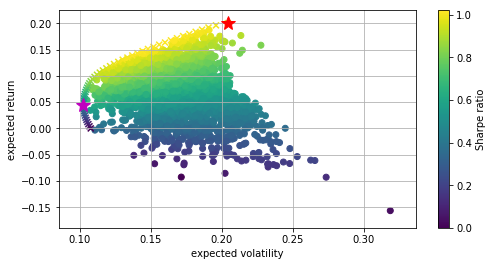

In [55]:
plt.figure(figsize=(8,4))
# random portfolio composition
plt.scatter(pvols, prets, c=prets/pvols, marker='o')
# efficient frontier
plt.scatter(tvols, trets, c=trets/tvols, marker='x')
# portfolio with highest Sharpe ratio
plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0], 'r*', markersize=15.0)
# minimum variance portfolio
plt.plot(statistics(optv['x'])[1], statistics(optv['x'])[0], 'm*', markersize=15.0)
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

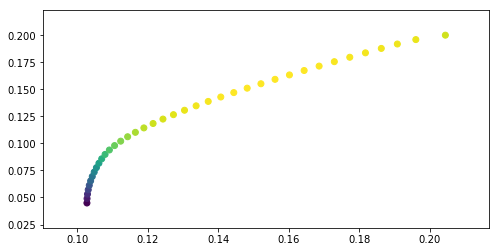

In [68]:
# now determine the capital line, that's the line that presents the risk/return of porfolios that are a mix
# of an asset portfolio and a risk-free asset (cash). This line should start at zero-risk and the risk free rate and 
# go linearly until it intersects the porfolio frontier

# index of the minimum vol
ind = np.argmin(tvols)
evols = tvols[ind:]
erets = trets[ind:]

plt.figure(figsize=(8,4))
# random portfolio composition
plt.scatter(evols, erets, c=erets/evols, marker='o')

In [69]:
tck = sci.splrep(evols,erets)

In [70]:
# spline functions of frontier and its first-order derivative
def f(x):
    return sci.splev(x, tck, der=0)
def df(x):
    return sci.splev(x, tck, der=1)

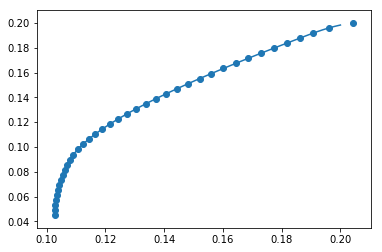

In [86]:
# verify spline fits
x = np.linspace(0.103,0.2, 50.)
plt.plot(x, f(x))
#plt.plot(x, df(x))
plt.scatter(evols, erets)

In order to solve the capital line $t(x)$, need to consider the following

$$t(x)=a+b.x$$
$$t(0)=r_{f} \iff a=r_{f}$$
$$t(x_{c})=f(x_{c}) \iff a + b.x_{c}=f(x_{c})$$
$$t'(x_{c})=f'(x_{c}) \iff b=f'(x_{c})$$

where $x_{c}$ is where capital line intercepts efficient frontier.
The are 3 unknowns, a, b and x_{c} and 3 equations. Can solve this system of linear equations numerically

In [90]:
# p[0]=a
# p[1]=b
# p[2] = x_c
def equations(p, rf=0.01):
    eq1 = rf - p[0]
    eq2 = rf + p[1] * p[2] - f(p[2])
    eq3 = p[1] - df(p[2])
    return eq1, eq2, eq3

In [92]:
# solve
opt = sco.fsolve(equations, [0.01, 0.5, 0.15])
opt

array([ 0.01      ,  0.9575894 ,  0.16734822])

In [94]:
# verify yield zeros
np.round(equations(opt),6)

array([ 0.,  0., -0.])

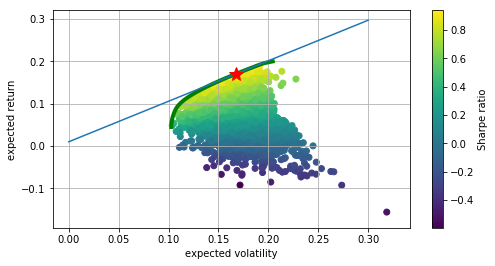

In [99]:
# plot capital line and tangency portfolio
plt.figure(figsize=(8, 4))
# random portfolio composition
plt.scatter(pvols, prets, c=(prets - 0.01) / pvols, marker='o')
# efficient frontier
plt.plot(evols, erets, 'g', lw=4.0)
# capital market line
cx = np.linspace(0.0, 0.3)
plt.plot(cx, opt[0] + opt[1] * cx, lw=1.5)
plt.plot(opt[2], f(opt[2]), 'r*', markersize=15.0)
plt.grid(True)
#plt.axhline(0, color='k', ls='—', lw=2.0)
#plt.axvline(0, color='k', ls='—', lw=2.0)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

In [100]:
    # constrainsts are
    # 1 - the return that of the tangency portfolio
    # 2 - the weights sum to 1 as before... ditto bounds 0<=w<-1
    cons = ({'type': 'eq', 'fun': lambda x: statistics(x)[0]-f(opt[2])},
    {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bnds = tuple((0,1) for x in range(noa))
    opts = sco.minimize(min_port_function, noa * [1./noa,],method='SLSQP', bounds=bnds, constraints=cons)

In [102]:
opts['x'].round(3)

array([ 0.288,  0.477,  0.115,  0.   ,  0.12 ])